In [7]:
import keras
import pandas as pd
# from tensorflow.python import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from sklearn.model_selection import train_test_split
import random
from random import shuffle
from skimage.io import imread
import numpy as np
import os
from sklearn.model_selection import KFold
from keras.layers import BatchNormalization, Input, DepthwiseConv2D, MaxPooling2D, concatenate, Activation
from data_science_toolkit.keras_utils import freeze_model_layers
from data_science_toolkit.keras_models import vgg_16_base
from data_science_toolkit.data_visualization import plot_confusion_matrix
import matplotlib.pyplot as plt

In [2]:
datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=90,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             fill_mode='reflect',
                             zoom_range=[0.8, 1.1],
                             horizontal_flip=True,
                             vertical_flip=True,
                             brightness_range=[0.8, 1.1],
                             channel_shift_range=12)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [3]:
train_dir = './train/train/'
test_dir = './test/test'

In [6]:
for i in range(5):
    print("Starting Model {} ===========================================================".format(i+1))
    print("Reading CSVs")
    train_df = pd.read_csv("train_df_{}.csv".format(i))
    val_df = pd.read_csv("val_df_{}.csv".format(i))
    train_df['train_file'] = train_df.Id.apply(lambda x: './train/train/{0}'.format(x))
    val_df['train_file'] = val_df.Id.apply(lambda x: './train/train/{0}'.format(x))
    print("Creating Generators")
    train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=train_dir,
                                                 x_col='Id',
                                                 y_col='Category',
                                                 target_size=(150, 150),
                                                 class_mode='categorical',
                                                 batch_size=32,
                                                 seed=7)

    validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df, directory=train_dir,
                                                 x_col='Id',
                                                 y_col='Category',
                                                shuffle=False,
                                                 target_size=(150, 150),
                                                 class_mode='categorical',
                                                 batch_size=100,
                                                 seed=7)
#     print("Creating Callbacks")
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
#     mc = ModelCheckpoint("vgg_16_best_model_ens_{}_step_1.h5".format(i), monitor='val_loss', mode='min', save_best_only=True)
#     # reduces learning rate if no improvement are seen
#     learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.5, min_lr=0.0000001)
    
#     print("Creating Model")
#     model = vgg_16_base((150, 150, 3), 'imagenet', 8)
#     freeze_model_layers(model, trainable_start=19)
#     # Probabilities produced by softmax will always sum to 1
#     default_adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#     model.compile(loss='categorical_crossentropy',optimizer=default_adam,metrics=['accuracy'])
    train_steps = train_generator.n//train_generator.batch_size
    validation_steps = validation_generator.n//validation_generator.batch_size
    
#     print("Fitting Model")
#     history = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=60,
#                               validation_data=validation_generator,validation_steps=validation_steps,
#                               callbacks=[es, mc, learning_rate_reduction],
#                               workers=6, max_queue_size=30)
    
#     print("Resetting Generators")
#     validation_generator.reset()
#     train_generator.reset()
    
#     print("Reloading Model for Second Step")
#     model = load_model("vgg_16_best_model_ens_{}_step_1.h5".format(i))
#     freeze_model_layers(model, trainable_start=15, trainable_end=None)
#     slow_adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#     model.compile(loss='categorical_crossentropy',optimizer=slow_adam,metrics=['accuracy'])
    
#     print("Creating New Callbacks")
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
#     mc = ModelCheckpoint("vgg_16_best_model_ens_{}_step_2.h5".format(i), monitor='val_loss', mode='min', save_best_only=True)
#     # reduces learning rate if no improvement are seen
#     learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.5, min_lr=0.0000001)
    
#     print("Fitting New Model")
#     history = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=500,
#                                   validation_data=validation_generator,validation_steps=validation_steps,
#                                   callbacks=[es, mc, learning_rate_reduction],
#                                   workers=6, max_queue_size=30)
    
    print("Resetting Generators again")
    validation_generator.reset()
    train_generator.reset()

    print("Reloading Model for Third Step")
    model = load_model("vgg_16_best_model_ens_{}_step_2.h5".format(i))
    freeze_model_layers(model, trainable_start=11, trainable_end=None)
    default_adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    slow_adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='categorical_crossentropy',optimizer=slow_adam,metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
    mc = ModelCheckpoint("vgg_16_best_model_ens_{}_step_3.h5".format(i), monitor='val_loss', mode='min', save_best_only=True)
    # reduces learning rate if no improvement are seen
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.5, min_lr=0.0000001)
    history = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=500,
                                  validation_data=validation_generator,validation_steps=validation_steps,
                                  callbacks=[es, mc, learning_rate_reduction],
                                  workers=6, max_queue_size=30)
# Batch Norm before Pooling:
# Epoch 63/500
# 112/112 [==============================] - 6s 50ms/step - loss: 0.0746 - acc: 0.9711 - val_loss: 0.0857 - val_acc: 0.9663
# Batch Norm after Pooling:
# Epoch 40/500
# 112/112 [==============================] - 6s 54ms/step - loss: 0.0834 - acc: 0.9660 - val_loss: 0.0881 - val_acc: 0.9650
# Batch Norm after Pooling - Added extra norms:
# Epoch 67/500
# 112/112 [==============================] - 6s 54ms/step - loss: 0.0790 - acc: 0.9693 - val_loss: 0.0770 - val_acc: 0.9675
# Batch Norm before Pooling - Added extra norms:
# w/e
# Added extra layers:
# 0.0663 or something

Starting Model 1 ===========================================================
Reading CSVs
Creating Generators
Found 3600 validated image filenames belonging to 8 classes.
Found 900 validated image filenames belonging to 8 classes.
Resetting Generators again
Reloading Model for Third Step
Froze all layers except 11 to 21.  Model must be compiled after this!
Epoch 1/500
112/112 [==============================] - 12s 110ms/step - loss: 0.4082 - acc: 0.8747 - val_loss: 0.3335 - val_acc: 0.8944
Epoch 2/500
112/112 [==============================] - 10s 85ms/step - loss: 0.2839 - acc: 0.9015 - val_loss: 0.3488 - val_acc: 0.8811
Epoch 3/500
112/112 [==============================] - 9s 82ms/step - loss: 0.2703 - acc: 0.9060 - val_loss: 0.2942 - val_acc: 0.9011
Epoch 4/500
112/112 [==============================] - 9s 81ms/step - loss: 0.2293 - acc: 0.9163 - val_loss: 0.3616 - val_acc: 0.8756
Epoch 5/500
112/112 [==============================] - 9s 82ms/step - loss: 0.2185 - acc: 0.9300 - val

In [ ]:
# for i in range(5):
#     print("Starting Model {} ===========================================================".format(i+1))
#     print("Reading CSVs")
#     train_df = pd.read_csv("train_df_{}.csv".format(i))
#     val_df = pd.read_csv("val_df_{}.csv".format(i))
#     train_df['train_file'] = train_df.Id.apply(lambda x: './train/train/{0}'.format(x))
#     val_df['train_file'] = val_df.Id.apply(lambda x: './train/train/{0}'.format(x))
#     print("Creating Generators")
#     train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=train_dir,
#                                                  x_col='Id',
#                                                  y_col='Category',
#                                                  target_size=(150, 150),
#                                                  class_mode='categorical',
#                                                  batch_size=32,
#                                                  seed=7)

#     validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df, directory=train_dir,
#                                                  x_col='Id',
#                                                  y_col='Category',
#                                                 shuffle=False,
#                                                  target_size=(150, 150),
#                                                  class_mode='categorical',
#                                                  batch_size=100,
#                                                  seed=7)
#     print("Creating Callbacks")
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
#     mc = ModelCheckpoint("best_model_ens_{}.h5".format(i), monitor='val_loss', mode='min', save_best_only=True)
#     # reduces learning rate if no improvement are seen
#     learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
#                                                 patience=4,
#                                                 verbose=1,
#                                                 factor=0.5,
#                                                 min_lr=0.0000001)
#     print("Creating Model")
#     model = get_model()
#     train_steps = train_generator.n//train_generator.batch_size
#     validation_steps = validation_generator.n//validation_generator.batch_size
#     print("Fitting Model")
#     history = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=500,
#                               validation_data=validation_generator,validation_steps=validation_steps,
#                               callbacks=[es, mc, learning_rate_reduction],
#                               workers=6, max_queue_size=30)
# # Batch Norm before Pooling:
# # Epoch 63/500
# # 112/112 [==============================] - 6s 50ms/step - loss: 0.0746 - acc: 0.9711 - val_loss: 0.0857 - val_acc: 0.9663
# # Batch Norm after Pooling:
# # Epoch 40/500
# # 112/112 [==============================] - 6s 54ms/step - loss: 0.0834 - acc: 0.9660 - val_loss: 0.0881 - val_acc: 0.9650
# # Batch Norm after Pooling - Added extra norms:
# # Epoch 67/500
# # 112/112 [==============================] - 6s 54ms/step - loss: 0.0790 - acc: 0.9693 - val_loss: 0.0770 - val_acc: 0.9675
# # Batch Norm before Pooling - Added extra norms:
# # w/e
# # Added extra layers:
# # 0.0663 or something

In [18]:
ens_idx = 2
saved_model = load_model("vgg_16_best_model_ens_{}_step_3.h5".format(ens_idx))
val_df = pd.read_csv("val_df_{}.csv".format(ens_idx))
val_df['train_file'] = val_df.Id.apply(lambda x: './train/train/{0}'.format(x))

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df, directory=train_dir,
                                             x_col='Id',
                                             y_col='Category',
                                            shuffle=False,
                                             target_size=(150, 150),
                                             class_mode='categorical',
                                             batch_size=100,
                                             seed=7)
num_name_dict = {v:k for k,v in validation_generator.class_indices.items()}

Found 900 validated image filenames belonging to 8 classes.


In [19]:
def show_errors(validation_generator, saved_model, num_name_dict):
    plt.figure(figsize=(30, 30))
    i, j = 0, 0
    while i < 20 and j < 900:
        x_val, y_val = next(validation_generator)
        _pred = saved_model.predict(x_val)
        _num_preds = [np.argmax(_pred[i,:]) for i in range(_pred.shape[0])]
        _str_preds = [num_name_dict[x] for x in _num_preds]
        _num_true = [np.argmax(y_val[i,:]) for i in range(y_val.shape[0])]
        _str_true = [num_name_dict[x] for x in _num_true]
        for idx, (pred, true) in enumerate(list(zip(_str_preds, _str_true))):
            plt.subplot(6, 5, i+1)
            if pred != true and i < 20:
                plt.imshow(x_val[idx])
                plt.title("Idx: {}, Pred: {}, Act: {}".format(idx, pred, true))
                i += 1
        j += 1

In [20]:
# show_errors(validation_generator, saved_model, num_name_dict)

In [21]:
validation_generator.reset()
final_preds = []
final_true = []
for j in range(validation_steps):
    x_val, y_val = next(validation_generator)
    _pred = saved_model.predict(x_val)
    _num_preds = [np.argmax(_pred[i,:]) for i in range(_pred.shape[0])]
    _str_preds = [num_name_dict[x] for x in _num_preds]
    _num_true = [np.argmax(y_val[i,:]) for i in range(y_val.shape[0])]
    _str_true = [num_name_dict[x] for x in _num_true]
    final_preds.extend(_str_preds)
    final_true.extend(_str_true)

<Figure size 720x720 with 0 Axes>

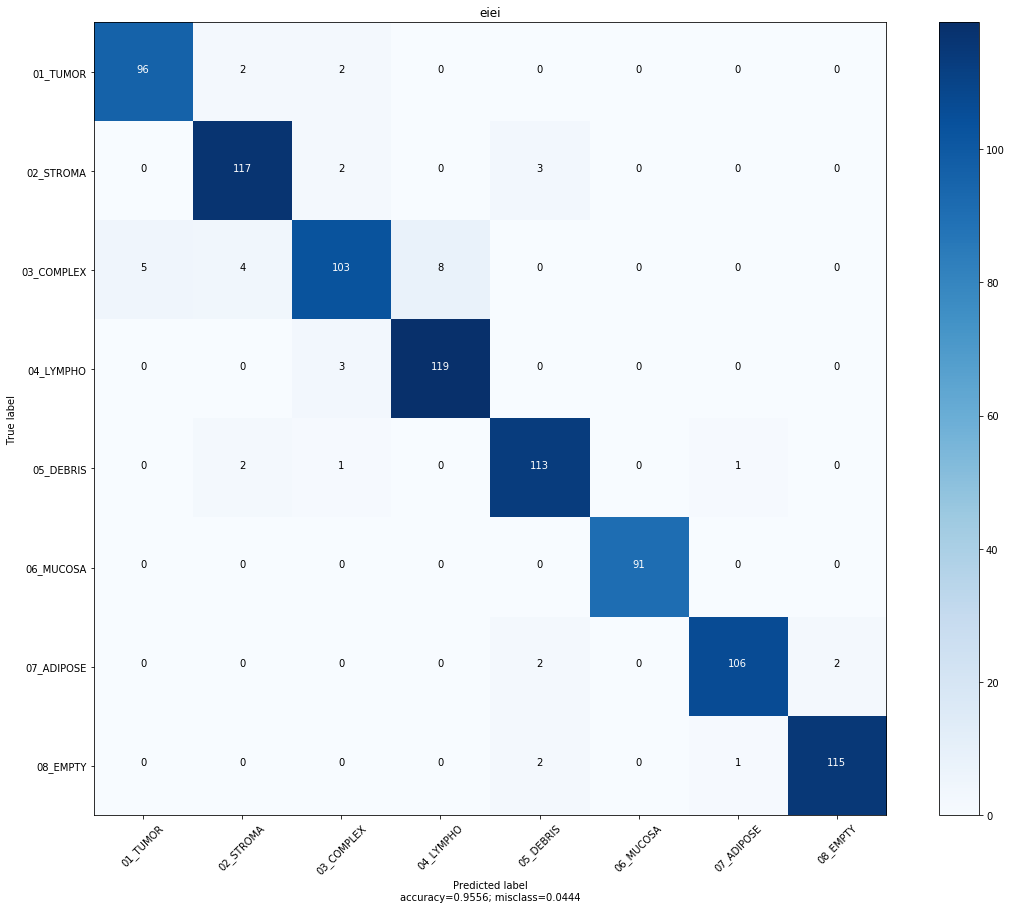

In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(final_true, 
                 final_preds, 
                 labels=list(validation_generator.class_indices.keys()))
np.set_printoptions(precision=2)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm=cm, normalize=False, target_names=list(validation_generator.class_indices.keys()), title="eiei")
plt.show()

In [51]:
final_test_preds = [None for _ in range(5)]

In [52]:
ens_idx = 0
test_generator = test_datagen.flow_from_directory('./test',classes=['test'],target_size=(150,150),
                                                 shuffle=False,
                                                 class_mode=None,
                                                 batch_size=1,
                                                 seed=7)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
saved_model = load_model("vgg_16_best_model_ens_{}_step_3.h5".format(ens_idx))
final_test_preds[ens_idx]=saved_model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

Found 500 images belonging to 1 classes.
500/500 [==============================] - 3s 6ms/step


In [53]:
ens_idx = 1
test_generator = test_datagen.flow_from_directory('./test',classes=['test'],target_size=(150,150),
                                                 shuffle=False,
                                                 class_mode=None,
                                                 batch_size=1,
                                                 seed=7)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
saved_model = load_model("vgg_16_best_model_ens_{}_step_3.h5".format(ens_idx))
final_test_preds[ens_idx]=saved_model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

Found 500 images belonging to 1 classes.
500/500 [==============================] - 3s 6ms/step


In [54]:
ens_idx = 2
test_generator = test_datagen.flow_from_directory('./test',classes=['test'],target_size=(150,150),
                                                 shuffle=False,
                                                 class_mode=None,
                                                 batch_size=1,
                                                 seed=7)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
saved_model = load_model("vgg_16_best_model_ens_{}_step_3.h5".format(ens_idx))
final_test_preds[ens_idx]=saved_model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

Found 500 images belonging to 1 classes.
500/500 [==============================] - 3s 6ms/step


In [55]:
ens_idx = 3
test_generator = test_datagen.flow_from_directory('./test',classes=['test'],target_size=(150,150),
                                                 shuffle=False,
                                                 class_mode=None,
                                                 batch_size=1,
                                                 seed=7)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
saved_model = load_model("vgg_16_best_model_ens_{}_step_3.h5".format(ens_idx))
final_test_preds[ens_idx]=saved_model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

Found 500 images belonging to 1 classes.
500/500 [==============================] - 3s 6ms/step


In [56]:
ens_idx = 4
test_generator = test_datagen.flow_from_directory('./test',classes=['test'],target_size=(150,150),
                                                 shuffle=False,
                                                 class_mode=None,
                                                 batch_size=1,
                                                 seed=7)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
saved_model = load_model("vgg_16_best_model_ens_{}_step_3.h5".format(ens_idx))
final_test_preds[ens_idx]=saved_model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

Found 500 images belonging to 1 classes.
500/500 [==============================] - 3s 6ms/step


In [57]:
np_final_test_preds = np.array(final_test_preds)

In [58]:
avged_test_preds = np.mean(np_final_test_preds, axis=0)

In [59]:
num_preds = [np.argmax(avged_test_preds[i,:]) for i in range(avged_test_preds.shape[0])]
# num_name_dict = {v:k for k,v in test_generator.class_indices.items()}
str_preds = [num_name_dict[x] for x in num_preds]
# test_generator.filenames
# test_files = glob.glob('/kaggle/input/syde522/test/test/*.png')

In [60]:
curr_str_preds = pd.read_csv('submission.csv').Category.tolist()

In [64]:
# for pred, curr_pred in list(zip(str_preds, curr_str_preds)):
#     if pred != curr_pred:
#         print("here")

In [65]:
test_file_id = [os.path.basename(test_file) for test_file in test_generator.filenames]
test_submission = pd.DataFrame({'Id': test_file_id, 'Category': str_preds})
test_submission.to_csv('ens_submission.csv', index=False)